## In this notebook, we explore integration approximation methods for:

### Weakly singular $\iint _T g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

### Strongly singular $\iint _T \nabla g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

$\Lambda_1^E \left(\begin{bmatrix} x\\y \\0\end{bmatrix}\right) = \begin{bmatrix}x \\y \\0 \end{bmatrix}$

In [1]:
import numpy, scipy, pandas, itertools
import matplotlib.pyplot as plt

# side-by side display of pandas data frames
from IPython.display import display, HTML
CSS = """
.output {flex-direction: row;}
"""
HTML('<style>{}</style>'.format(CSS))

In [2]:
# define the Triangle element class with methods

class Triangle:
    def __init__(self,a,b,c):

        # initialize the vertices
        self.a = numpy.array(a)
        self.b = numpy.array(b)
        self.c = numpy.array(c)
        
        # define the Jacobian and its inverse
        self._col1 = self.a - self.c
        self._col2 = self.b - self.c
        self._col3 = numpy.cross(self._col1,self._col2)/numpy.linalg.norm(numpy.cross(self._col1,self._col2))
        self.Jac = numpy.array([self._col1,self._col2,self._col3]).T
        self.JacInv = numpy.linalg.inv(self.Jac)
        self.J = numpy.linalg.norm(numpy.cross(self._col1,self._col2))
        
        self.area = self.J/2.
        
        # initialize the quadrature points
        self.qp = []
        self.n = 0
        
    # get map from reference to this triangle
    def refToPhys(self,point):
        return numpy.dot(self.Jac, numpy.array([point[0],point[1],0])) + self.c
    
    # plot the triangle
    def plotElement(self):
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(*self.a)
        ax.scatter(*self.b)
        ax.scatter(*self.c)
        #from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        #poly3d = [1,0,0]
        #ax.add_collection3d(Poly3DCollection(poly3d, facecolors=['blue'], linewidths=1))
        plt.show()

    def setUniformQP(self,n):
        self.n = n
        refQP = [numpy.array([j+0.5,n+.5-i],float)/n for i in range(n+1) for j in range(i)]
        self.qp = [self.refToPhys(point) for point in refQP]
        return len(self.qp)
        
    def plotQP(self):
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        [ax.scatter(*point) for point in self.qp]
        plt.show()
        
    def coordsDuffy(self,t):
        t1 = t[0]
        t2 = t[1]
        return numpy.array((1.-(t1+1.)/2.)*self.c + \
                           (t1+1.)/2. * (1.- (t2+1.)/2.)*self.a + \
                           (t1+1.)*(t2+1.)*self.b/4.)

In [3]:
# kernels

# weakly singular
def g(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return numpy.exp(-1j*k*R)/(4*numpy.pi*R)

# strongly singular, coordinate-wise
def gradg_x(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return (r[0]-rp[0]) * numpy.exp(-1j*R)*(-1j*k*R - 1.)/numpy.power(R,3)

def gradg_y(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return (r[1]-rp[1]) * numpy.exp(-1j*R)*(-1j*k*R - 1.)/numpy.power(R,3)

def gradg_z(r,rp,k=1):
    R = numpy.linalg.norm(numpy.array(r)-numpy.array(rp))
    return (r[2]-rp[2]) * numpy.exp(-1j*R)*(-1j*k*R - 1.)/numpy.power(R,3)

In [4]:
# integrate g(r,r')*div(\Lambda_1) via uniform midpoint rule
def approxUniform(T,g,rp,n,k=1):
    T.setUniformQP(n)
    value = 0.0
    for point in T.qp:
        testA = point - T.a
        testB = point - T.b
        testA = testA/numpy.linalg.norm(testA)
        testB = testB/numpy.linalg.norm(testB)
        weight = 0.0
        if numpy.dot(testA,testB) == 1. or numpy.dot(testA,testB) == -1.:
            weight = 2.*n*n
        else:
            weight = n*n
        value += g(point,rp,k)*\
            (T.JacInv[0][0]*T.Jac[0][0] + T.JacInv[1][0]*T.Jac[0][1] + T.JacInv[2][0]*T.Jac[0][2] + \
             T.JacInv[0][1]*T.Jac[1][0] + T.JacInv[1][1]*T.Jac[1][1] + T.JacInv[2][1]*T.Jac[1][2])*\
            T.J/weight
    return value

# Duffy transform approximation
def approxDuffy(T,g,rp,n,k=1):
    # determine quadrature rule for Duffy transform in the (t1,t2) coordinates
    value = 0.0
    tQP = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[0],\
                                            numpy.polynomial.legendre.leggauss(n)[0])]
    tW = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[1],\
                                            numpy.polynomial.legendre.leggauss(n)[1])]
    D1 = Triangle(rp,T.a,T.b)
    D2 = Triangle(rp,T.b,T.c)
    D3 = Triangle(rp,T.c,T.a)
    for D in [D1, D2, D3]:
        for i in range(len(tQP)):
            t1, t2 = tQP[i]
            tensorweight = tW[i][0]*tW[i][1]
            value += g(D.coordsDuffy([t1,t2]),rp,k)*\
                (T.JacInv[0][0]*T.Jac[0][0] + T.JacInv[1][0]*T.Jac[0][1] + T.JacInv[2][0]*T.Jac[0][2] + \
                 T.JacInv[0][1]*T.Jac[1][0] + T.JacInv[1][1]*T.Jac[1][1] + T.JacInv[2][1]*T.Jac[1][2])*\
                (t1+1.)/4.*D.area * tensorweight
    return  value

In [5]:
# test the Duffy transform
A = (1,1,5)
B = (0,2,5)
C = (0,1,5)
T = Triangle(A,B,C)

print '(-1,-1) got mapped to',T.coordsDuffy((-1,-1))
print '(-1, 0) got mapped to',T.coordsDuffy((-1,0))
print '(-1,+1) got mapped to',T.coordsDuffy((-1,1))

print '(+1,-1) got mapped to',T.coordsDuffy((1,-1))
print '(+1, 0) got mapped to',T.coordsDuffy((1,0))
print '(+1,+1) got mapped to',T.coordsDuffy((1,1))

print 'area is',T.area

(-1,-1) got mapped to [0. 1. 5.]
(-1, 0) got mapped to [0. 1. 5.]
(-1,+1) got mapped to [0. 1. 5.]
(+1,-1) got mapped to [1. 1. 5.]
(+1, 0) got mapped to [0.5 1.5 5. ]
(+1,+1) got mapped to [0. 2. 5.]
area is 0.5


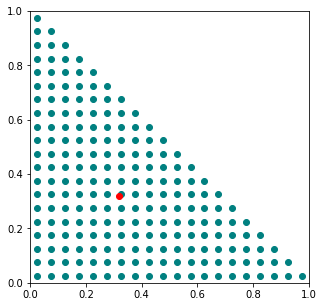

In [6]:
%matplotlib inline
A = (1,0,0)
B = (0,1,0)
C = (0,0,0)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))

T.setUniformQP(20)
plt.figure(figsize=(5,5))
for point in T.qp:
    plt.scatter(point[0],point[1],color='teal')
plt.scatter(rp[0],rp[1],color='red')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

### Weakly singular $\iint _T g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

#### test under translation and rotation

In [7]:
# apply the uniform midpoint rule for approximation
A = (1,0,0)
B = (0,1,0)
C = (0,0,0)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
maxLevel = 20
steps = 15

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [8]:
# check the result under the translation y+=1, z+=5
A = (1,1,5)
B = (0,2,5)
C = (0,1,5)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
maxLevel = 20
steps = 15

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniformTest1 = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniformTest1.columns = ['Unif Real', 'Unif Imag']
dataUniformTest1.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [9]:
# check the result under a rotation
A = (0,0,1)
B = (0,1,0)
C = (0,0,0)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
maxLevel = 20
steps = 15

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniformTest2 = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniformTest2.columns = ['Unif Real', 'Unif Imag']
dataUniformTest2.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [10]:
display(dataUniform)
display(dataUniformTest1)
display(dataUniformTest2)

,Unif Real,Unif Imag
1,0.599069,-0.157409
3,0.492430,-0.078261
6,0.320719,-0.086924
15,0.507699,-0.081285
21,0.331624,-0.078129
28,0.365439,-0.082922
45,0.352722,-0.080909
55,0.352150,-0.078119
66,7.588425,-0.082522
91,0.362982,-0.081313


,Unif Real,Unif Imag
1,0.599069,-0.157409
3,0.492430,-0.078261
6,0.334871,-0.095347
15,0.519594,-0.087373
21,0.334376,-0.080191
28,0.362685,-0.082836
45,0.357410,-0.082813
55,0.357561,-0.080416
66,7.590654,-0.083194
91,0.360715,-0.080405


,Unif Real,Unif Imag
1,0.599069,-0.157409
3,0.492430,-0.078261
6,0.320719,-0.086924
15,0.507699,-0.081285
21,0.331624,-0.078129
28,0.365439,-0.082922
45,0.352722,-0.080909
55,0.352150,-0.078119
66,7.588425,-0.082522
91,0.362982,-0.081313


#### compare midpoint uniform approx to Duffy transform approximation

In [11]:
# apply the uniform midpoint rule for approximation
A = (.1,0,0)
B = (0,.13,0)
C = (0,0,.2)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
maxLevel = 400
steps = 15

results = [approxUniform(T,g,rp,int(i)) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [12]:
# apply the Duffy transform for approximation
A = (.1,0,0)
B = (0,.13,0)
C = (0,0,.2)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))
maxLevel = 30
steps = 15

results = [approxDuffy(T,g,rp,int(i)) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [13]:
display(dataUniform)
display(dataDuffy)

,Unif Real,Unif Imag
1,0.035637,-0.002805
435,0.070475,-0.002819
1711,0.076042,-0.002819
3741,0.071942,-0.002811
6670,0.072116,-0.002810
10296,0.076191,-0.002810
14878,0.071750,-0.002810
20100,0.071872,-0.002809
26335,0.071869,-0.002808
33153,0.071831,-0.002808


,Duffy Real,Duffy Imag
3,0.072803,-0.002806
27,0.073063,-0.002806
75,0.072620,-0.002806
147,0.072387,-0.002806
243,0.072258,-0.002806
363,0.072183,-0.002806
507,0.072135,-0.002806
675,0.072102,-0.002806
867,0.072080,-0.002806
1083,0.072063,-0.002806


#### performance profiling

In [14]:
# that required this many quadrature points
n=20 # for uniform
print 'unif  approx:',len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]),\
    'with approx value', approxUniform(T,g,rp,n)
n = 8 # for Duffy
print 'Duffy approx:',3*len(numpy.polynomial.legendre.leggauss(int(n))[0])**2,\
    'with approx value', approxDuffy(T,g,rp,n)

unif  approx: 210 with approx value (0.07133356948420083-0.002813103654896307j)
Duffy approx: 192 with approx value (0.072386646606325-0.002806097372936511j)


In [15]:
%%timeit
n = 20
approxUniform(T,g,rp,n)

100 loops, best of 3: 4.98 ms per loop


In [16]:
%%timeit
n = 8
approxDuffy(T,g,rp,n)

100 loops, best of 3: 4.32 ms per loop


In [17]:
# that required this many quadrature points
n = 5 # for uniform
print 'unif  approx:',len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]),\
    'with approx value', approxUniform(T,g,rp,n)
n = 2 # for Duffy
print 'Duffy approx:',3*len(numpy.polynomial.legendre.leggauss(int(n))[0])**2,\
    'with approx value', approxDuffy(T,g,rp,n)

unif  approx: 15 with approx value (0.07765529165852536-0.00280605227564583j)
Duffy approx: 12 with approx value (0.07280320858226248-0.0028060973765058474j)


In [18]:
%%timeit
n = 5
approxUniform(T,g,rp,n)

The slowest run took 386.86 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 516 µs per loop


In [19]:
%%timeit
n = 2
approxDuffy(T,g,rp,n)

The slowest run took 9.55 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.04 ms per loop


### Strongly singular $\iint _T \nabla g(\vec{r},\vec{r}') \nabla \cdot \Lambda _1 ^T (\vec{r}') \, dr'$

In [301]:
A = (0.20,0,0)
B = (0,0.21,0)
C = (0,0,0.23)
T = Triangle(A,B,C)
rp = T.refToPhys((1./numpy.pi , 1/numpy.pi))

freqHz     = 30e6;
eps0       = 8.85418781761e-12;
mu0        = numpy.pi*4e-7;
c_light    = 1./numpy.sqrt(eps0*mu0);
wavelength = c_light/freqHz;
#eta        = numpy.sqrt(mu0/eps0);
#omega      = 2*numpy.pi*freqHz;
k0         = 2.*numpy.pi/wavelength;

### x- component

In [302]:
# apply the uniform midpoint rule for approximation
maxLevel = 100
steps = 15
results = [approxUniform(T,gradg_x,rp,int(i),k0)/(4*numpy.pi) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

In [303]:
# apply the Duffy transform for approximation
maxLevel = 100
steps = 15
results = [approxDuffy(T,gradg_x,rp,int(i),k0)/(4*numpy.pi) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real part', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [306]:
# Duffy transform and singularity extraction approximation
def approxDuffySingEx_x(T,g,rp,n,k=1):
    value = 0.0
    # triangular subdivision
    D1 = Triangle(rp,T.a,T.b)
    D2 = Triangle(rp,T.b,T.c)
    D3 = Triangle(rp,T.c,T.a)
    # auxiliary functions
    dxp_dt1 = lambda D,t1,t2 : -0.5*D.c[0] + 0.5*(1.-(t2+1.)/2.)*D.a[0] + (t2+1.)/4.*D.b[0]
    dyp_dt1 = lambda D,t1,t2 : -0.5*D.c[1] + 0.5*(1.-(t2+1.)/2.)*D.a[1] + (t2+1.)/4.*D.b[1]
    dzp_dt1 = lambda D,t1,t2 : -0.5*D.c[2] + 0.5*(1.-(t2+1.)/2.)*D.a[2] + (t2+1.)/4.*D.b[2]
    fk = lambda D,t2 : numpy.linalg.norm([dxp_dt1(D,-1,t2), dyp_dt1(D,-1,t2), dzp_dt1(D,-1,t2)])
    fkcubed = lambda D,t2 : numpy.power(fk(D,t2),3.)
    # regular part
    t1t2QP = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[0],\
                                           numpy.polynomial.legendre.leggauss(n)[0])]
    t1t2W = [i for i in itertools.product(numpy.polynomial.legendre.leggauss(n)[1],\
                                          numpy.polynomial.legendre.leggauss(n)[1])]
    model = lambda D,t1,t2 : 1./((t1+1.) * fkcubed(D,t2)) * dxp_dt1(D,-1,t2)
    kernel = lambda D,t1,t2 : g(D.coordsDuffy([t1,t2]),rp,k) * (t1 + 1.)
    extracted = lambda D,t1,t2 : model(D,t1,t2) + kernel(D,t1,t2)
    for D in [D1, D2, D3]:
        for i in range(len(t1t2QP)):
            t1, t2 = t1t2QP[i]
            tensorweight = t1t2W[i][0]*t1t2W[i][1]
            value += 1./(16.*numpy.pi) * D.area * extracted(D,t1,t2)*\
                     (T.JacInv[0][0]*T.Jac[0][0] + T.JacInv[1][0]*T.Jac[0][1] + T.JacInv[2][0]*T.Jac[0][2] + \
                      T.JacInv[0][1]*T.Jac[1][0] + T.JacInv[1][1]*T.Jac[1][1] + T.JacInv[2][1]*T.Jac[1][2])*\
                     tensorweight
    # singular part
    t2QP = numpy.polynomial.legendre.leggauss(n)[0]
    t2W = numpy.polynomial.legendre.leggauss(n)[1]
    for D in [D1, D2, D3]:
        for i in range(len(t2QP)):
            t2 = t2QP[i]
            value += -1./(16.*numpy.pi) * D.area * \
                     1./fkcubed(D,t2) * dxp_dt1(D,-1.,t2) * numpy.log(2. * fk(D,t2)) * \
                     (T.JacInv[0][0]*T.Jac[0][0] + T.JacInv[1][0]*T.Jac[0][1] + T.JacInv[2][0]*T.Jac[0][2] + \
                      T.JacInv[0][1]*T.Jac[1][0] + T.JacInv[1][1]*T.Jac[1][1] + T.JacInv[2][1]*T.Jac[1][2])*\
                     t2W[i]
    return value

In [307]:
# apply the Duffy transform and singularity extraction for approximation
maxLevel = 20
steps = 15
results = [approxDuffySingEx_x(T,gradg_x,rp,int(i),k0) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffySing = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffySing.columns = ['Duf & SingEx Real part', 'Duf & SingEx Imag']
dataDuffySing.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [308]:
display(dataUniform)
display(dataDuffy)
display(dataDuffySing)

,Unif Real,Unif Imag
1,-0.473261,0.017404
36,7.178761,-0.007393
120,0.030033,0.000755
253,-0.015351,0.000700
435,-0.083935,0.000814
666,-9.352972,0.002836
946,0.324765,0.000471
1275,-0.089576,0.000763
1653,0.039562,0.000669
2080,-0.902875,0.001004


,Duffy Real part,Duffy Imag
3,0.035336,0.000383
192,0.080437,0.000624
675,0.083291,0.000655
1452,0.083944,0.000664
2523,0.084192,0.000667
3888,0.084312,0.000669
5547,0.084379,0.000670
7500,0.084420,0.000671
9747,0.084448,0.000671
12288,0.084467,0.000672


,Duf & SingEx Real part,Duf & SingEx Imag
3,0.067653,0.000383
12,0.090876,0.000512
27,0.107186,0.000515
75,0.115027,0.000563
108,0.125712,0.000601
147,0.129126,0.000613
243,0.131806,0.000624
300,0.135917,0.000638
363,0.137551,0.000643
507,0.138992,0.000647


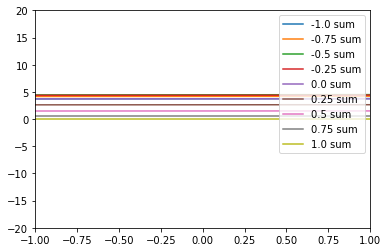

In [314]:
# asymptotic analysis

dxp_dt1 = lambda D,t1,t2 : -0.5*D.c[0] + 0.5*(1.-(t2+1.)/2.)*D.a[0] + (t2+1.)/4.*D.b[0]
dyp_dt1 = lambda D,t1,t2 : -0.5*D.c[1] + 0.5*(1.-(t2+1.)/2.)*D.a[1] + (t2+1.)/4.*D.b[1]
dzp_dt1 = lambda D,t1,t2 : -0.5*D.c[2] + 0.5*(1.-(t2+1.)/2.)*D.a[2] + (t2+1.)/4.*D.b[2]
fk = lambda D,t2 : numpy.linalg.norm([dxp_dt1(D,-1,t2), dyp_dt1(D,-1,t2), dzp_dt1(D,-1,t2)])
fkcubed = lambda D,t2 : numpy.power(fk(D,t2),3.)
    
T = Triangle((.2,0,0),(0,.2,0),(0,0,0))
rp = (0,0,0)
f = lambda t1,t2 : 1./((t1+1.) * fkcubed(T,t2)) * dxp_dt1(T,-1,t2)
g = lambda t1,t2 : gradg_x(T.coordsDuffy([t1,t2]),rp,k0) * (t1 + 1.)
x = numpy.linspace(-1+1E-12,1.,1000)

model = lambda D,t1,t2 : 1./((t1+1.) * fkcubed(D,t2)) * dxp_dt1(D,-1,t2)
kernel = lambda D,t1,t2 : gradg_x(D.coordsDuffy([t1,t2]),rp,k0) * (t1 + 1.)
extracted = lambda D,t1,t2 : model(D,t1,t2) + kernel(D,t1,t2)
    
for t2 in [-1.,-.75,-.5,-.25,0.,.25,.5,.75,1.]:
    plt.plot(x, [numpy.imag(model(T,p,t2)+kernel(T,p,t2)) for p in x],label=str(t2)+' sum')
plt.xlim([-1,1])
plt.ylim([-20,20])
plt.legend()
plt.show()

### y- component

In [ ]:
# apply the uniform midpoint rule for approximation
maxLevel = 200
steps=15
results = [approxUniform(T,gradgy,rp,int(i),k0) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

# apply the Duffy transform for approximation
maxLevel = 100
steps=15
results = [approxDuffy(T,gradgy,rp,int(i),k0) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real part', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [ ]:
display(dataUniform)
display(dataDuffy)

### z- component

In [ ]:
# apply the uniform midpoint rule for approximation
maxLevel = 200
steps=15
results = [approxUniform(T,gradgz,rp,int(i),k0) for i in numpy.linspace(1,maxLevel,steps)]
dataUniform = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataUniform.columns = ['Unif Real', 'Unif Imag']
dataUniform.index = [len([numpy.array([j+0.5,int(n)+.5-i],float)/int(n) for i in range(int(n)+1) for j in range(i)]) for n in numpy.linspace(1,maxLevel,steps)]

# apply the Duffy transform for approximation
maxLevel = 100
steps=15
results = [approxDuffy(T,gradgz,rp,int(i),k0) for i in numpy.linspace(2,maxLevel,steps)]
dataDuffy = pandas.DataFrame([numpy.real(results),numpy.imag(results)]).T
dataDuffy.columns = ['Duffy Real', 'Duffy Imag']
dataDuffy.index = [3*len(numpy.polynomial.legendre.leggauss(int(i))[0])**2 for i in numpy.linspace(1,maxLevel,steps)]

In [ ]:
display(dataUniform)
display(dataDuffy)